## Биометрическая идентификация по данным обработки ЭЭГ

Если вы запускаете эту программу в первый раз, разкомментируйте следующую строку, чтобы сгенерировать необходимые файлы. Программа может работать достаточно долго!

In [1]:
#%run packet_proccess.ipynb

Несколько раз запустив наш алгоритм для обработки всех файлов, мы получили полиномы, настроенные на аппроксимацию сигналов с электродов для всех обработанных субъектов, и сохранили их в виде матрицы. Теперь продемонстрируем возможность идентификации пациента на основании этих данных

In [17]:
from scipy.io import loadmat
import time
import pandas as pd
import numpy as np
import sympy
import pickle
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

Загрузим наши данные в матричном виде

In [3]:
with open("resources/subjects_mx.pkl", 'rb') as f:
    data = pickle.load(f)
mx, mx_key = data['mx'], data['key']

Выберем файл данных для проверки индентификации

In [4]:
subj = loadmat(f"resources/subject_08.mat")

In [5]:
electrodes = [
    'Fp1',
    'Fp2',
    'Fc5',
    'Fz',
    'Fc6',
    'T7',
    'Cz',
    'T8',
    'P7',
    'P3',
    'Pz',
    'P4',
    'P8',
    'O1',
    'Oz',
    'O2'
]
col_map = ['time']+electrodes

subj = pd.DataFrame({
    col: arr for col, arr in zip(col_map, np.transpose(subj['SIGNAL']))
})

norm_map = [subj[el].values.max()-subj[el].values.min() for el in electrodes]
mean_map = [subj[el].mean() for el in electrodes]
n_points = 10
ids = np.random.randint(0, subj.index.size, n_points)
rows = list(subj[electrodes].values[ids])
for i, row in enumerate(rows):
    rows[i] = (rows[i]-mean_map)/norm_map
    rows[i] = np.concatenate([rows[i], [1]])
rows = np.array(rows)

l = np.einsum('mij,kj->mki', mx.astype(np.float32), rows)
r = (subj[electrodes].values[ids]-mean_map)/norm_map

Оценка близости тестовых данных к данным субъекта, для которого сконструирована каждая матрица уравнений, производится на основе косинусной меры
$$ Score_i = {{Matrix_i \cdot Data^T} \over \sqrt{(Matrix_i \cdot Matrix_i^T)\cdot (Data \cdot Data^T)}} $$

In [12]:
score = np.array([np.einsum('ij,ij->', ll,r)/np.sqrt(np.einsum('ij,ij->', r,r)*np.einsum('ij,ij->', ll,ll)) for ll in l])


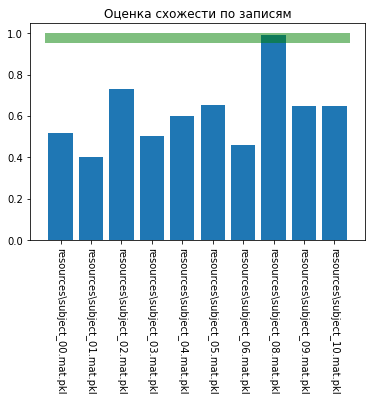

In [50]:
ind = np.arange(len(score))
fig, ax = plt.subplots()
plt.xticks(ind, mx_key[0], rotation = -90)
ax.bar(ind, score)
ax.add_patch(Rectangle((-0.5,0.95), len(score), 0.05, alpha=0.5, facecolor="g"))
ax.set_title("Оценка схожести по записям")
plt.show()

In [15]:
p = mx_key[0][np.where(score>0.95)[0][0]]
print(f"Источники, показавшие схожесть более 95%: {p}")

Источники, показавшие схожесть более 95%: resources\subject_08.mat.pkl
